In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = pd.read_csv("dataset/X_data.csv")
y = pd.read_csv("dataset/y_data.csv").Status

In [3]:
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                   'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_unordered_features = ["Drug", "Sex"]
categorical_ordered_features = ["Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

Code explaination in EvaluationKB

In [4]:
class CustomKNNImputer(KNNImputer):
    def __init__(self, n_neighbors=5, weights="uniform", **kwargs):
        super().__init__(n_neighbors=n_neighbors, weights=weights, **kwargs)
        self.n_neighbors = n_neighbors
        self.weights = weights
        global y
        self.y = y.copy()
    
    def fit(self, X, *args, **kwargs):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X_transformed.loc[indices] = imputer.transform(X.loc[indices])
        return X_transformed

class CustomSimpleImputer(SimpleImputer):
    def __init__(self, strategy="most_frequent", **kwargs):
        super().__init__(strategy=strategy, **kwargs)
        self.strategy = strategy
        global y
        self.y = y.copy()
        
    def fit(self, X, *args, **kwargs):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = SimpleImputer(strategy=self.strategy).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X_transformed.loc[indices] = imputer.transform(X.loc[indices])
        return X_transformed

The explainiation of the CustomOrdinalEncoder is in EvaluationKB. Here the difference is that after the SMOTENC balancer we have to rapresent attributes as indeces, not strings

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, custom_orders):
        self.custom_orders = custom_orders
        self.encoders = {}

    def fit(self, X, y=None):
        for col, categories in self.custom_orders.items():
            encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=-1)
            encoder.fit(X[:, col].reshape(-1, 1))
            self.encoders[col] = encoder
        return self

    def transform(self, X):
        for col, encoder in self.encoders.items():
            X[:, col] = encoder.transform(X[:, col].reshape(-1, 1)).flatten()
        return X

custom_orders = {
    0: ['N', 'Y'],
    1: ['N', 'Y'],
    2: ['N', 'Y'],
    3: ['N', 'S', 'Y'],
    4: ['1.0', '2.0', '3.0', '4.0']
}

In [6]:
from imblearn.base import BaseSampler
from collections import Counter

class SmoteNCBalancer(BaseSampler):
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors

    def _fit_resample(self, X, y):
        return self.fit_resample(X, y)
        
    def fit_resample(self, X, y):
        self.class_counts = Counter(y)
        smotenc = SMOTENC(random_state=0, k_neighbors=self.k_neighbors,\
                                  categorical_features=[11, 12, 13, 14, 15, 16, 17],\
                                 sampling_strategy={"High chance":self.class_counts["High chance"],\
                                                    "Low chance":self.class_counts["Low chance"],\
                                                    "Transplant needed":self.class_counts["Low chance"]})
        X_resampled, y_resampled = smotenc.fit_resample(X, y)
        
        return X_resampled, y_resampled

class ENNBalancer(BaseSampler):
    def __init__(self, k_neighbors_cleaning=5):
        self.k_neighbors_cleaning = k_neighbors_cleaning

    def _fit_resample(self, X, y):
        return self.fit_resample(X, y)
        
    def fit_resample(self, X, y):
        ncl = EditedNearestNeighbours(sampling_strategy=["High chance"], n_neighbors=self.k_neighbors_cleaning)
        X_resampled, y_resampled = ncl.fit_resample(X, y)
        
        return X_resampled, y_resampled

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", CustomKNNImputer()),
            ("scaler", RobustScaler())
        ]), numeric_features),
        ("cat_unord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
        ]), categorical_unordered_features),
        ("cat_ord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
        ]), categorical_ordered_features)
    ]
)

In [8]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat_unord', OneHotEncoder(), [11, 12]),
        ('cat_ord', CustomOrdinalEncoder(custom_orders), [13, 14, 15, 16, 17])
    ],
    remainder='passthrough'
)

clf_RandomForest = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('sampler1', SmoteNCBalancer()),
        ("preprocessor2", preprocessor2),
        ('sampler2', ENNBalancer()),
        ("classifier", RandomForestClassifier(random_state=0, n_jobs=-1))
    ]
)
clf_KNNeighbor = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('sampler1', SmoteNCBalancer()),
        ("preprocessor2", preprocessor2),
        ('sampler2', ENNBalancer()),
        ("classifier", KNeighborsClassifier(n_jobs=-1))
    ]
)
clf_AdaBoostGNB = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('sampler1', SmoteNCBalancer()),
        ("preprocessor2", preprocessor2),
        ('sampler2', ENNBalancer()),
        ("classifier", AdaBoostClassifier(random_state=0, estimator=GaussianNB(), algorithm="SAMME"))
    ]
)
clf_LogReg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('sampler1', SmoteNCBalancer()),
        ("preprocessor2", preprocessor2),
        ('sampler2', ENNBalancer()),
        ("classifier", LogisticRegression(random_state=0))
    ]
)

clf_RandomForest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomKNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('cat_unord',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomSimpleImputer())]),
                                                  ['Drug', 'Sex']),...
                ('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_unord', OneHotEncoder(),
                                                  [11, 12]),
                                                 ('cat_ord',
                                                  CustomOrdinalEncoder(custom_orders={0: ['N',
                                                                                          'Y'],
                                                                                      1: ['N',
                                                                                          'Y'],
                                                                                      2: ['N',
                                                                                          'Y'],
                                                                                      3: ['N',
                                                                                          'S',
                                                                                          'Y'],
                                                                                      4: ['1.0',
                                                                                          '2.0',
                                                                                          '3.0',
                                                                                          '4.0']}),
                                                  [13, 14, 15, 16, 17])])),
                ('sampler2', ENNBalancer()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [9]:
# RandomForest
param_grid_RandomForest = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),

    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__max_depth": range(2, 8),
    "classifier__criterion": ["gini", "entropy"],
}

# KNNeighbor
param_grid_KNNeighbor = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__n_neighbors": range(3, 18, 2),
}

# Parametri per AdaBoostGNB
param_grid_AdaBoostGNB = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__learning_rate": [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5],
}

# Parametri per LogReg
param_grid_LogReg = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__C": [0.01, 0.1, 1, 10, 100],
}

In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scorer = "f1_weighted"

Print procedure explained in EvaluationKB

Random Forest best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 2, 'preprocessor__num__imputer__n_neighbors': 12, 'classifier__max_depth': 6, 'classifier__criterion': 'gini'}
                   precision    recall  f1-score   support

      High chance       0.94      0.70      0.80        23
       Low chance       0.79      0.88      0.83        17
Transplant needed       0.33      1.00      0.50         2

         accuracy                           0.79        42
        macro avg       0.69      0.86      0.71        42
     weighted avg       0.85      0.79      0.80        42

                   precision    recall  f1-score   support

      High chance       0.95      0.83      0.89        24
       Low chance       0.94      0.94      0.94        16
Transplant needed       0.40      1.00      0.57         2

         accuracy                           0.88        42
        macro avg       0.76      0.92      0.80        42
     weighted avg      

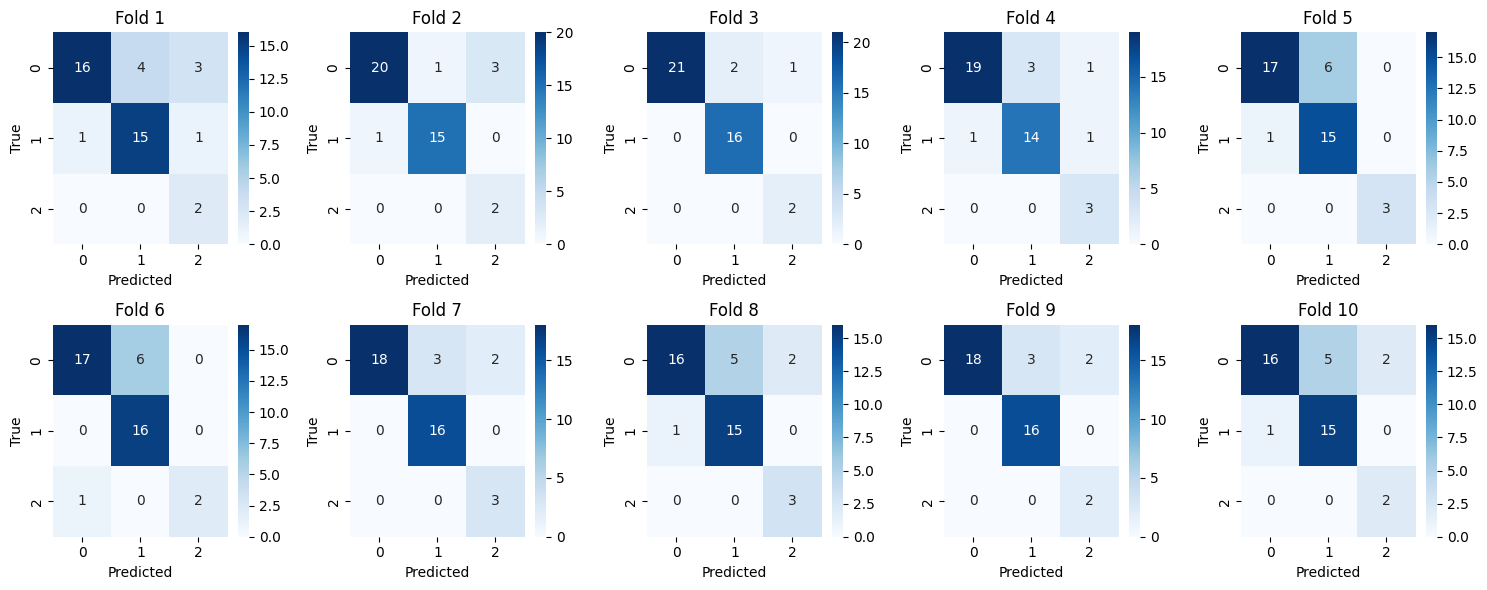

In [11]:
clfrf = RandomizedSearchCV(
    estimator = clf_RandomForest, 
    param_distributions=param_grid_RandomForest,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfrf.fit(X, y)

best_params = clfrf.best_params_
print("Random Forest best parameters:", best_params)

f_weighted_scores1 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfrf.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores1.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

KNN best parameters: {'sampler2__k_neighbors_cleaning': 5, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 13, 'classifier__n_neighbors': 11}
                   precision    recall  f1-score   support

      High chance       0.83      0.65      0.73        23
       Low chance       1.00      0.35      0.52        17
Transplant needed       0.11      1.00      0.20         2

         accuracy                           0.55        42
        macro avg       0.65      0.67      0.48        42
     weighted avg       0.87      0.55      0.62        42

                   precision    recall  f1-score   support

      High chance       0.85      0.71      0.77        24
       Low chance       0.78      0.44      0.56        16
Transplant needed       0.15      1.00      0.27         2

         accuracy                           0.62        42
        macro avg       0.59      0.72      0.53        42
     weighted avg       0.79      0.62      0.67        42

   

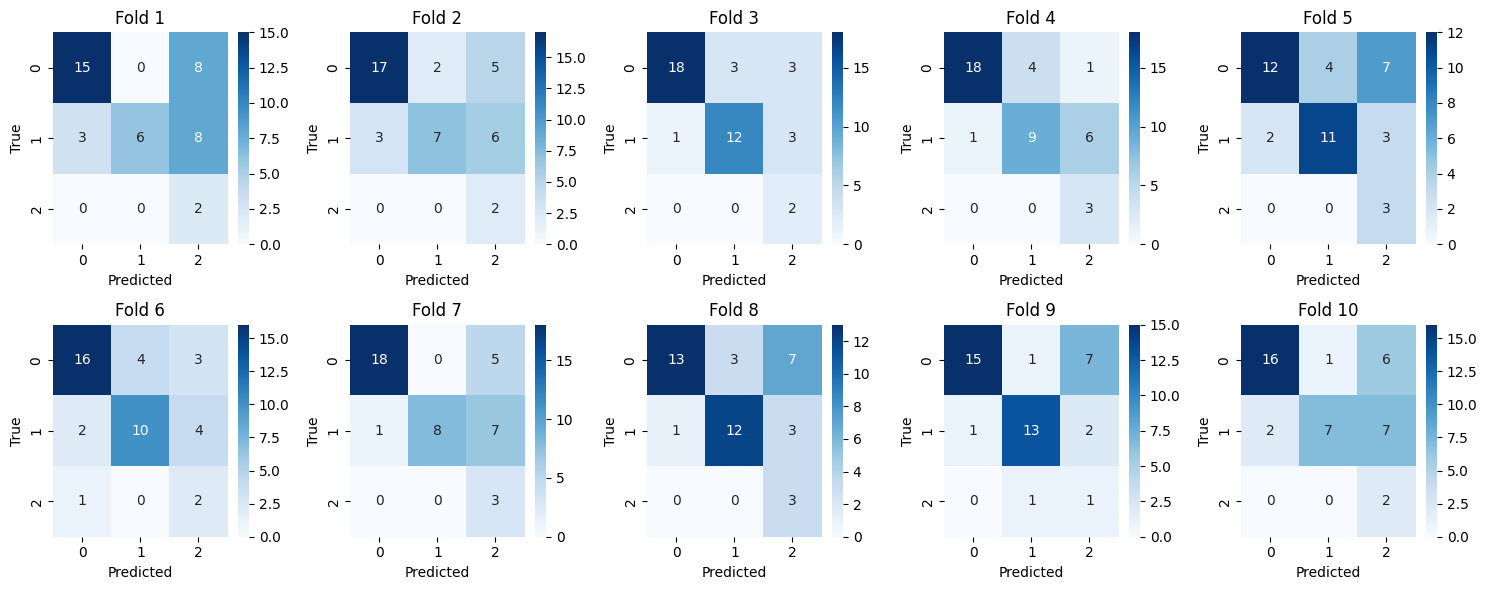

In [12]:
clfknn = RandomizedSearchCV(
    estimator = clf_KNNeighbor, 
    param_distributions=param_grid_KNNeighbor,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfknn.fit(X, y)

best_params = clfknn.best_params_
print("KNN best parameters:", best_params)

f_weighted_scores2 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfknn.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores2.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

ADABoost best parameters: {'sampler2__k_neighbors_cleaning': 5, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 11, 'classifier__learning_rate': 1}
                   precision    recall  f1-score   support

      High chance       0.88      0.65      0.75        23
       Low chance       0.75      0.53      0.62        17
Transplant needed       0.15      1.00      0.27         2

         accuracy                           0.62        42
        macro avg       0.60      0.73      0.55        42
     weighted avg       0.79      0.62      0.67        42

                   precision    recall  f1-score   support

      High chance       0.94      0.67      0.78        24
       Low chance       0.75      0.56      0.64        16
Transplant needed       0.15      1.00      0.27         2

         accuracy                           0.64        42
        macro avg       0.62      0.74      0.56        42
     weighted avg       0.83      0.64      0.70        4

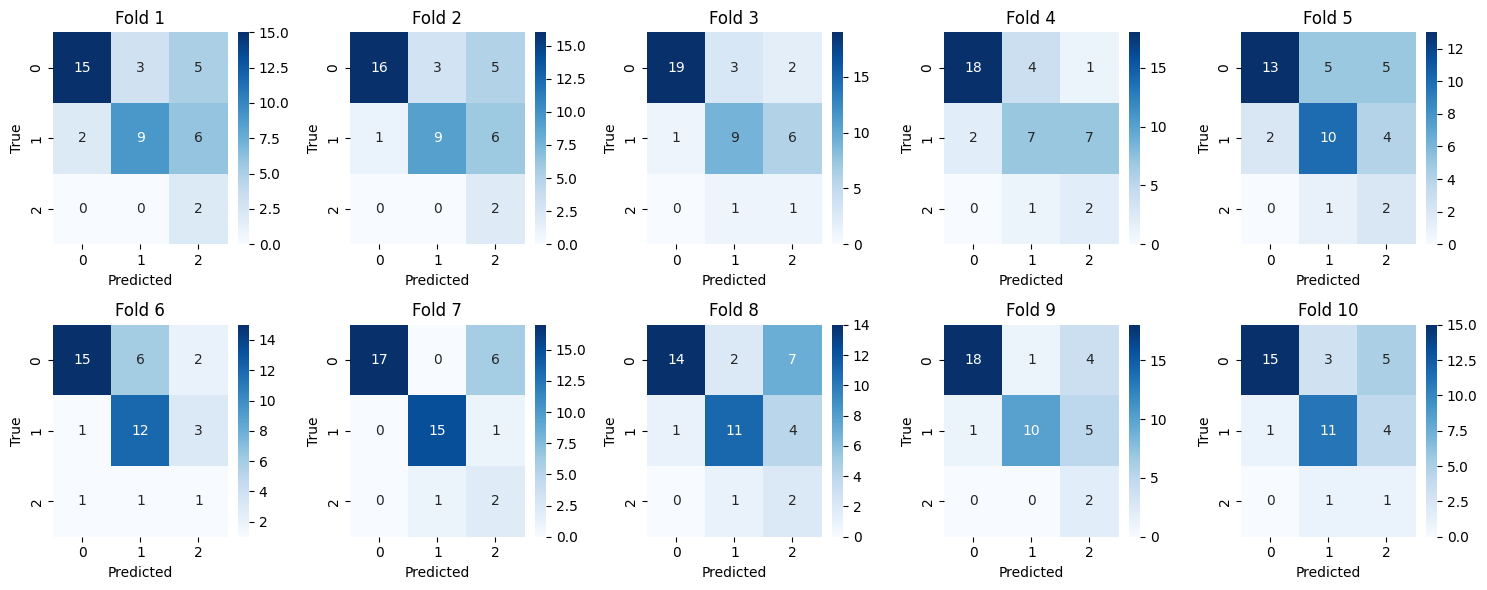

In [13]:
clfadagnb = RandomizedSearchCV(
    estimator = clf_AdaBoostGNB, 
    param_distributions=param_grid_AdaBoostGNB,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfadagnb.fit(X, y)

best_params = clfadagnb.best_params_
print("ADABoost best parameters:", best_params)

f_weighted_scores3 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfadagnb.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores3.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

Logistic Regression best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 12, 'classifier__C': 0.1}
                   precision    recall  f1-score   support

      High chance       0.81      0.57      0.67        23
       Low chance       0.60      0.53      0.56        17
Transplant needed       0.18      1.00      0.31         2

         accuracy                           0.57        42
        macro avg       0.53      0.70      0.51        42
     weighted avg       0.70      0.57      0.61        42

                   precision    recall  f1-score   support

      High chance       0.83      0.79      0.81        24
       Low chance       0.86      0.75      0.80        16
Transplant needed       0.40      1.00      0.57         2

         accuracy                           0.79        42
        macro avg       0.69      0.85      0.73        42
     weighted avg       0.82      0.79      0.79        

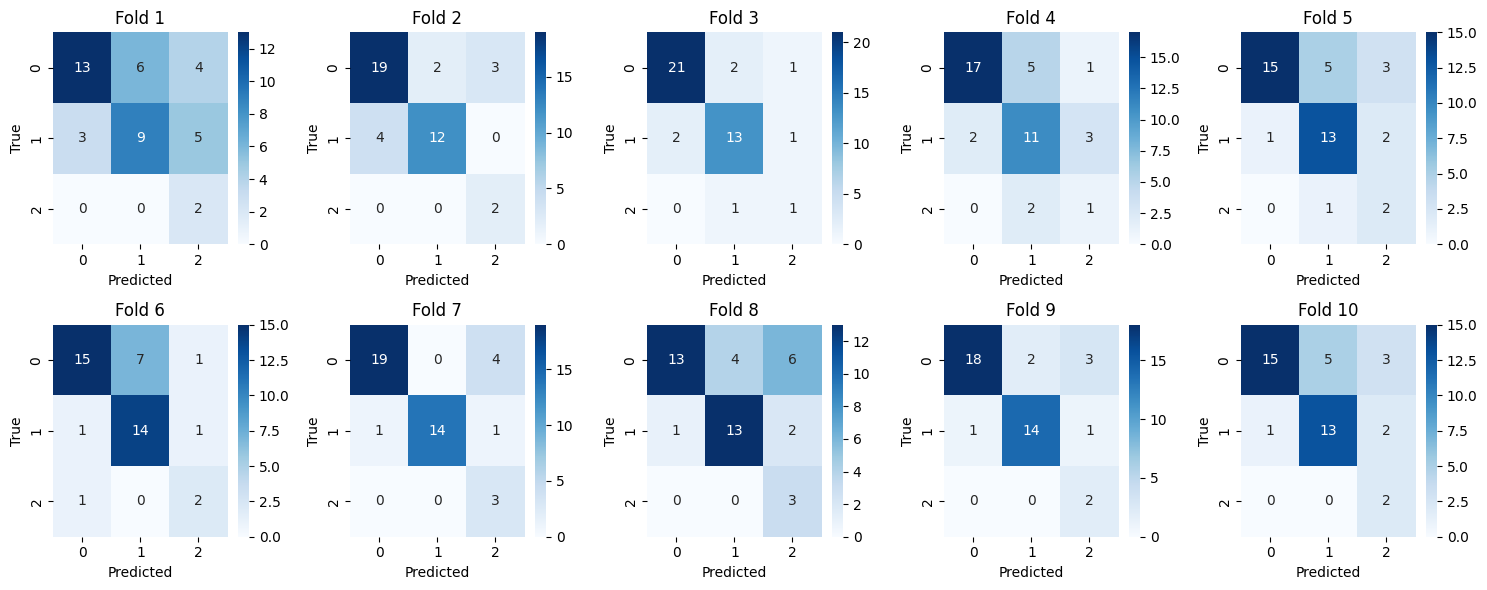

In [14]:
clflr = RandomizedSearchCV(
    estimator = clf_LogReg, 
    param_distributions=param_grid_LogReg,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clflr.fit(X, y)

best_params = clflr.best_params_
print("Logistic Regression best parameters:", best_params)

f_weighted_scores4 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clflr.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores4.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

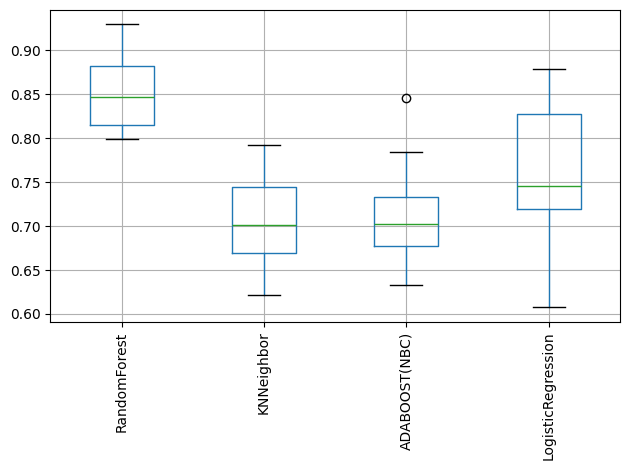

In [15]:
cv_scores = {
    'RandomForest': f_weighted_scores1,
    'KNNeighbor': f_weighted_scores2,
    'ADABOOST(NBC)': f_weighted_scores3,
    'LogisticRegression': f_weighted_scores4
}

df_cv_scores = pd.DataFrame(cv_scores)

df_cv_scores.boxplot()
plt.xticks(ticks=range(1, len(df_cv_scores.columns) + 1), labels=df_cv_scores.columns, rotation=90)
plt.tight_layout()
#plt.savefig("stat_result(ord).png")
plt.show()

C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


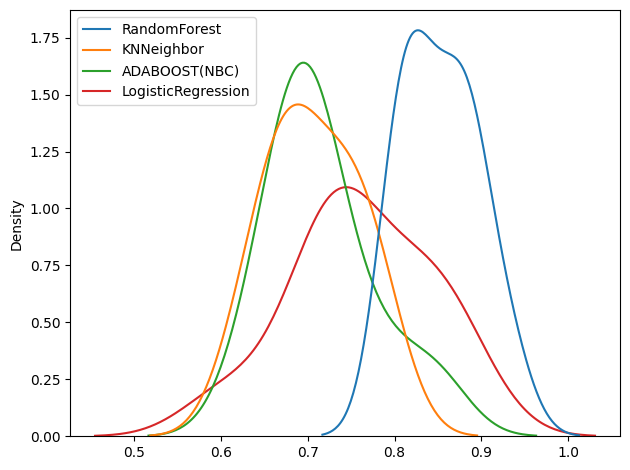

In [16]:
import scipy.stats as stats

sns.kdeplot(data=df_cv_scores)
plt.tight_layout()
#plt.savefig("ord KDE plot.png")
plt.show()

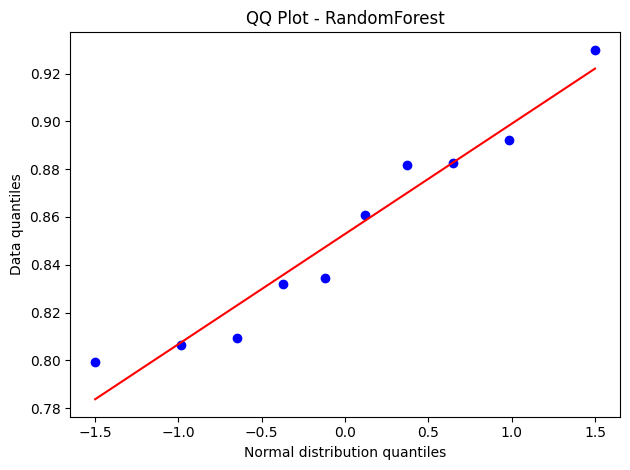

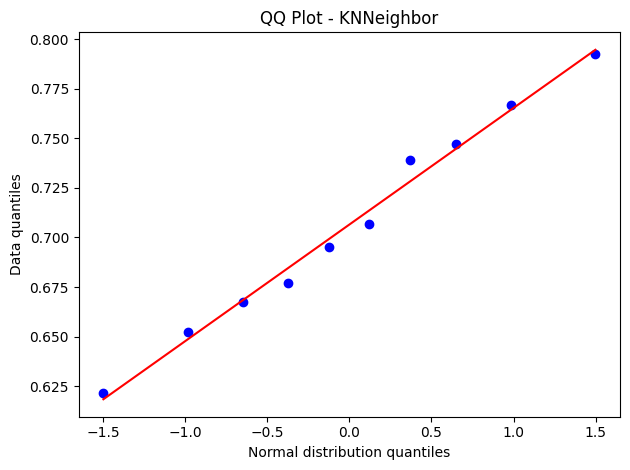

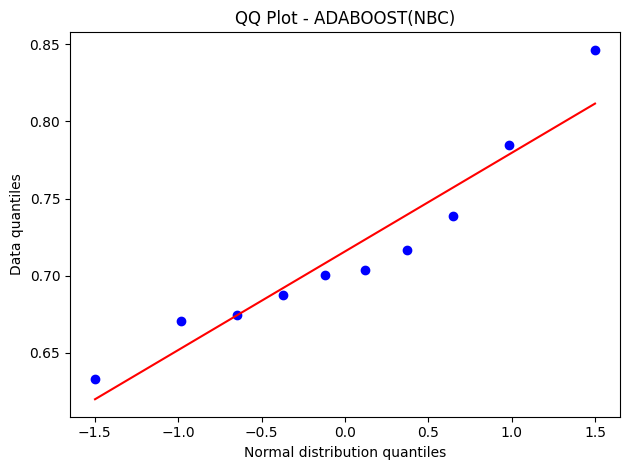

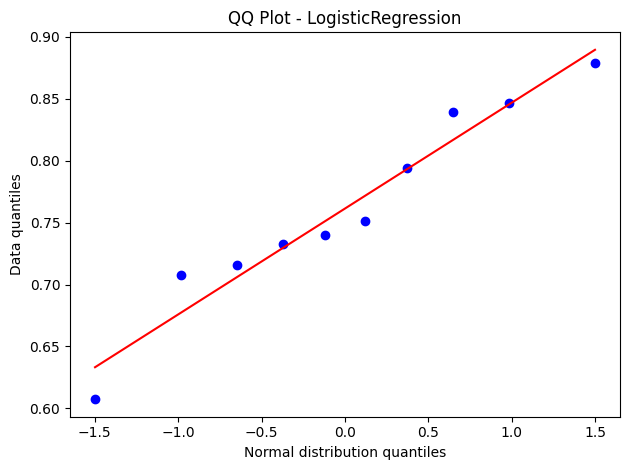

In [17]:
for i, col in enumerate(df_cv_scores.columns):
    stats.probplot(df_cv_scores[col], plot=plt)
    plt.title(f'QQ Plot - {col}')
    plt.xlabel('Normal distribution quantiles')
    plt.ylabel('Data quantiles')
    plt.tight_layout()
    #plt.savefig(f"ord_Test_QQ_Plot_{col}.png")

    plt.show()

In [18]:
statistic, p_value = stats.levene(cv_scores["RandomForest"], 
                                 cv_scores["KNNeighbor"], 
                                 cv_scores["ADABOOST(NBC)"], 
                                 cv_scores["LogisticRegression"])

print("Levene's statistic:", statistic)
print("p value:", p_value)

if p_value < 0.05:
    print("There is evidence to reject the null hypothesis of equal variances (homoscedasticity).")
else:
    print("There is no evidence to reject the null hypothesis of equal variances (homoscedasticity).")

Levene's statistic: 0.7247095913982834
p value: 0.5438932151626796
There is no evidence to reject the null hypothesis of equal variances (homoscedasticity).


In [19]:
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import wilcoxon

kruskal_result = kruskal(cv_scores["RandomForest"], 
                         cv_scores["KNNeighbor"], 
                         cv_scores["ADABOOST(NBC)"], 
                         cv_scores["LogisticRegression"])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least two groups.")
    models = ["RandomForest", "KNNeighbor", "ADABOOST(NBC)", "LogisticRegression"]
    couples = list(combinations(models, 2))
    
    for _ in couples:
        m1, m2 = _
        wilcoxon_result = wilcoxon(cv_scores[m1], cv_scores[m2])
        
        print("Comparing", m1, "and", m2)
        print("Wilcoxon statistic:", wilcoxon_result.statistic)
        print("p value:", wilcoxon_result.pvalue)
        
        if wilcoxon_result.pvalue < 0.05:
            print("There is a statistically relevant difference between", m1, "and", m2)
        else:
            print("There is no statistically relevant difference between", m1, "and", m2)
        print("----")
else:
    print("There are no statistically relevant difference between groups.")

Kruskal-Wallis statistic: 19.584878048780496
p value: 0.000206909690193277
There is a statistically relevant difference between at least two groups.
Comparing RandomForest and KNNeighbor
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and KNNeighbor
----
Comparing RandomForest and ADABOOST(NBC)
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and ADABOOST(NBC)
----
Comparing RandomForest and LogisticRegression
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and LogisticRegression
----
Comparing KNNeighbor and ADABOOST(NBC)
Wilcoxon statistic: 24.0
p value: 0.76953125
There is no statistically relevant difference between KNNeighbor and ADABOOST(NBC)
----
Comparing KNNeighbor and LogisticRegression
Wilcoxon statistic: 5.0
p value: 0.01953125
There is a statistically relevant difference between KNNeighbo